# Predicting Chronic Kidney Disease based on health records
Given 24 health related attributes taken in 2-month period of 400 patients, using the information of the 158 patients with complete records to predict the outcome (i.e. whether one has chronic kidney disease) of the remaining 242 patients (with missing values in their records).

# Summary of Results
With proper tuning of parameters using cross-validation in the training set, the Random Forest Classfier achieves an accuracy of 90.1% and an ROC AUC of 99.0%. Lesson learnt: It happens that some pruning helps improve the performance of RF a lot.

# Load Modules and helper functions

In [169]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report,accuracy_score
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

def auc_scorer(clf, X, y, model): # Helper function to plot the ROC curve
    if model=='RF':
        fpr, tpr, _ = roc_curve(y, clf.predict_proba(X)[:,1])
    elif model=='SVM':
        fpr, tpr, _ = roc_curve(y, clf.decision_function(X))
    roc_auc = auc(fpr, tpr)

    plt.figure()    # Plot the ROC curve
    plt.plot(fpr, tpr, label='ROC curve from '+model+' model (area = %0.3f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

    return fpr,tpr,roc_auc

# from subprocess import check_output
# print(check_output(["ls", "../input"]).decode("utf8"))

# Load files

In [170]:
import csv
import pandas as pd
df = pd.read_csv('C:/Users/sony/Downloads/chronic_kidney_disease_full.csv')
print (df)

     age   bp     sg   al   su       rbc        pc         pcc          ba  \
0     48   80  1.020  1.0  0.0       NaN    normal  notpresent  notpresent   
1      7   50  1.020  4.0  0.0       NaN    normal  notpresent  notpresent   
2     62   80  1.010  2.0  3.0    normal    normal  notpresent  notpresent   
3     48   70  1.005  4.0  0.0    normal  abnormal     present  notpresent   
4     51   80  1.010  2.0  0.0    normal    normal  notpresent  notpresent   
5     60   90  1.015  3.0  0.0       NaN       NaN  notpresent  notpresent   
6     68   70  1.010  0.0  0.0       NaN    normal  notpresent  notpresent   
7     52  100  1.015  3.0  0.0    normal  abnormal     present  notpresent   
8     53   90  1.020  2.0  0.0  abnormal  abnormal     present  notpresent   
9     50   60  1.010  2.0  4.0       NaN  abnormal     present  notpresent   
10    63   70  1.010  3.0  0.0  abnormal  abnormal     present  notpresent   
11    68   70  1.015  3.0  1.0       NaN    normal     present  

# Cleaning and preprocessing of data for training a classifier

In [187]:
# Map text to 1/0 and do some cleaning
df[['htn','dm','cad','pe','ane']] = df[['htn','dm','cad','pe','ane']].replace(to_replace='yes',value=1)
df[['htn','dm','cad','pe','ane']] = df[['htn','dm','cad','pe','ane']].replace(to_replace='no',value=0)
df[['rbc','pc']] = df[['rbc','pc']].replace(to_replace='abnormal',value=1)
df[['rbc','pc']] = df[['rbc','pc']].replace(to_replace='normal',value=0)
df[['pcc','ba']] = df[['pcc','ba']].replace(to_replace='present',value=1)
df[['pcc','ba']] = df[['pcc','ba']].replace(to_replace='notpresent',value=0)
df[['appet']] = df[['appet']].replace(to_replace='good',value=1)
df[['appet']] = df[['appet']].replace(to_replace='poor',value=0)
df[['appet']] = df[['appet']].replace(to_replace='no',value=np.nan)
df['class'] = df['class'].replace(to_replace='ckd',value=1.0)
df['class'] = df['class'].replace(to_replace='ckd\t',value=1.0)
df['class'] = df['class'].replace(to_replace='notckd',value=0.0)
df['class'] = df['class'].replace(to_replace='no',value=0.0)
df.rename(columns={'classification':'class'},inplace=True)

In [190]:
# Further cleaning
import numpy as np
df['pe'] = df['pe'].replace(to_replace='good',value=0) # Not having pedal edema is good
df['appet'] = df['appet'].replace(to_replace='no',value=0)
df['cad'] = df['cad'].replace(to_replace='\tno',value=0)
df['dm'] = df['dm'].replace(to_replace='\tno',value=0)
df['dm'] = df['dm'].replace(to_replace='\tyes',value=1)
df['dm'] = df['dm'].replace(to_replace='yes',value=1)
df['dm'] = df['dm'].replace(to_replace=' ',value= np.nan)
#df.drop('id',axis=1,inplace=True)

In [191]:
df.head()

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,pcv,wbcc,rbcc,htn,dm,cad,appet,pe,ane,class
0,48,80,1.020,1.0,0.0,NaN,0.0,0.0,0.0,121.0,...,44.0,7800.0,5.2,1,1,0,1.0,0.0,0.0,1.0
1,7,50,1.020,4.0,0.0,NaN,0.0,0.0,0.0,NaN,...,38.0,6000.0,NaN,0,0,0,1.0,0.0,0.0,1.0
2,62,80,1.010,2.0,3.0,0.0,0.0,0.0,0.0,423.0,...,31.0,7500.0,NaN,0,1,0,0.0,0.0,1.0,1.0
3,48,70,1.005,4.0,0.0,0.0,1.0,1.0,0.0,117.0,...,32.0,6700.0,3.9,1,0,0,0.0,1.0,1.0,1.0
4,51,80,1.010,2.0,0.0,0.0,0.0,0.0,0.0,106.0,...,35.0,7300.0,4.6,0,0,0,1.0,0.0,0.0,1.0


# Check the portion of rows with NaN

- Now the data is cleaned with improper values labelled NaN. Let's see how many NaNs are there.
- Drop all the rows with NaN values, and build a model out of this dataset (i.e. df2)

In [192]:
df2 = df.dropna(axis=0)
df2['class'].value_counts()

0.0    115
1.0     43
Name: class, dtype: int64

# Examine correlations between different features

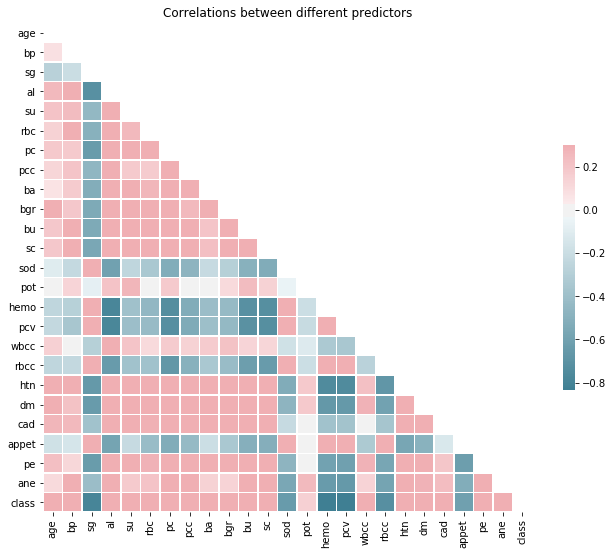

In [193]:
import matplotlib.pyplot as plt
import seaborn as sns
corr_df = df2.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr_df, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_df, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Correlations between different predictors')
plt.show()

## Split the set for training models further into a (sub-)training set and testing set.

In [194]:
from sklearn.model_selection import train_test_split, GridSearchCV
X_train, X_test, y_train, y_test = train_test_split(df2.iloc[:,:-1], df2['class'], 
                                                    test_size = 0.33, random_state=44,
                                                   stratify= df2['class'] )


In [195]:
print(X_train.shape)
print(X_test.shape)

(105, 24)
(53, 24)


In [196]:
y_train.value_counts()

0.0    76
1.0    29
Name: class, dtype: int64

# Choosing parameters with GridSearchCV with 10-fold cross validations.


Detailed classification report:
             precision    recall  f1-score   support

        0.0       1.00      1.00      1.00        39
        1.0       1.00      1.00      1.00        14

avg / total       1.00      1.00      1.00        53

Confusion Matrix:
[[39  0]
 [ 0 14]]


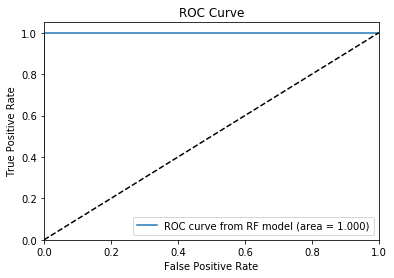

Best parameters:
{'class_weight': None, 'max_depth': 2, 'n_estimators': 8, 'random_state': 42}


In [200]:
from sklearn.ensemble import RandomForestClassifier
tuned_parameters = [{'n_estimators':[7,8,9,10,11,12,13,14,15,16],'max_depth':[2,3,4,5,6,None],
                     'class_weight':[None,{0: 0.33,1:0.67},'balanced'],'random_state':[42]}]
clf = GridSearchCV(RandomForestClassifier(), tuned_parameters, cv=10,scoring='f1')
clf.fit(X_train, y_train)

print("Detailed classification report:")
y_true, lr_pred = y_test, clf.predict(X_test)
print(classification_report(y_true, lr_pred))

confusion = confusion_matrix(y_test, lr_pred)
print('Confusion Matrix:')
print(confusion)

# Determine the false positive and true positive rates
fpr,tpr,roc_auc = auc_scorer(clf, X_test, y_test, 'RF')

print('Best parameters:')
print(clf.best_params_)
clf_best = clf.best_estimator_


# Examine feature importance
Since I pruned the forest (*max_depth*=2) and decrease the number of trees (*n_estimators*=8), not all features are used.

Text(0.5,1,'Feature Importance')

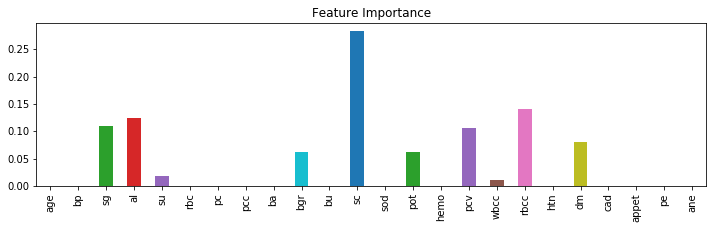

In [201]:
plt.figure(figsize=(12,3))
features = X_test.columns.values.tolist()
importance = clf_best.feature_importances_.tolist()
feature_series = pd.Series(data=importance,index=features)
feature_series.plot.bar()
plt.title('Feature Importance')

In [202]:
list_to_fill = X_test.columns[feature_series>0]
print(list_to_fill)

Index(['sg', 'al', 'su', 'bgr', 'sc', 'pot', 'pcv', 'wbcc', 'rbcc', 'dm'], dtype='object')


# Next, I examine the rest of the dataset (with missing values across the rows)
Are there correlations between occurence of missing values in a row? The plot suggests, seems no.

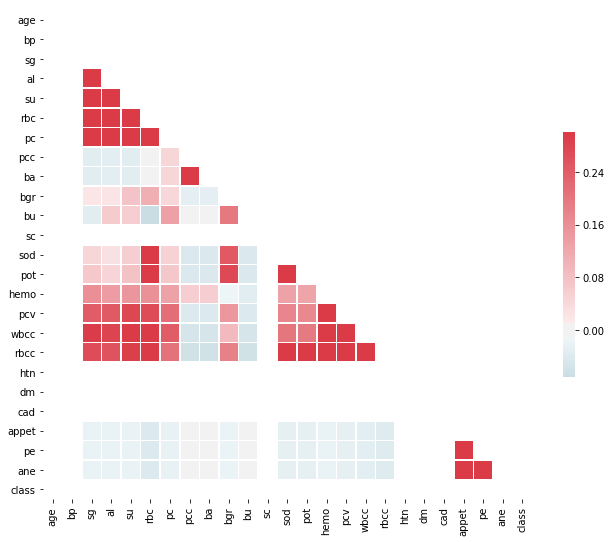

In [203]:
# Are there correlation in missing values?
corr_df = pd.isnull(df).corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr_df, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_df, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

# Make predictions with the best model selected above
I filled in all NaN with 0 and pass it to the trained classifier. The results are as follows:
- True positive = 180
- True negative = 35
- False positive = 0
- False negative = 27
----
- Accuracy = 90.19%
- ROC AUC = 99.0%

             precision    recall  f1-score   support

        0.0       0.56      1.00      0.71        25
        1.0       1.00      0.89      0.94       179

avg / total       0.95      0.90      0.91       204

Confusion Matrix:
[[ 25   0]
 [ 20 159]]
Accuracy: 0.901961


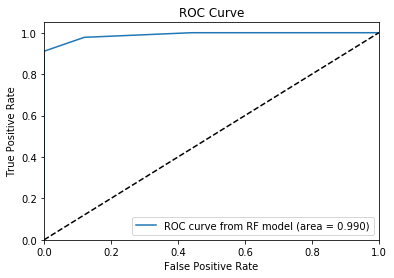

In [204]:
df2 = df.dropna(axis=0)
no_na = df2.index.tolist()
some_na = df.drop(no_na).apply(lambda x: pd.to_numeric(x,errors='coerce'))
some_na = some_na.fillna(0) # Fill up all Nan by zero.

X_test = some_na.iloc[:,:-1]
y_test = some_na['class']
y_true = y_test
lr_pred = clf_best.predict(X_test)
print(classification_report(y_true, lr_pred))

confusion = confusion_matrix(y_test, lr_pred)
print('Confusion Matrix:')
print(confusion)

print('Accuracy: %3f' % accuracy_score(y_true, lr_pred))
# Determine the false positive and true positive rates
fpr,tpr,roc_auc = auc_scorer(clf_best, X_test, y_test, 'RF')
 
